In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

In [2]:
DEVICE = 'cuda:0'

In [9]:
# A toy model with a diffuse and point source component

NN = 18

def model(z, sigma = .1, n_marg = NN):
    #z_marg = np.random.rand(n_marg)
    #z = np.hstack([z, z_marg])
    z = z * np.pi
    x = np.sin(z)**2
    return x

In [10]:
def noisemodel(x, z, sigma = 0.1):
    x = x + np.random.randn(*x.shape) * sigma
    return x

In [11]:
z0 = np.ones(8) * 0.25
zdim = len(z0)
x0 = model(z0)
print(x0, zdim)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5] 8


In [12]:
cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)

Creating new cache.


In [13]:
MAX_EPOCHS = 100
EXPECTED_N = 50000

In [14]:
intensity = None

for _ in range(3):
    if intensity is None:
        intensity = swyft.get_unit_intensity(expected_n=EXPECTED_N, dim=zdim)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
            factor_mask=intensity.factor_mask,
        )
    cache.grow(intensity)
    cache.simulate(model)
    points = swyft.Points(cache, intensity, noisemodel)
    re = swyft.RatioEstimator(points, device=DEVICE)
    re.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4])

Simulate:   0%|          | 189/50226 [00:00<00:26, 1888.91it/s]

Adding 50226 new samples. Run simulator!


Simulate: 100%|██████████| 50226/50226 [00:19<00:00, 2559.02it/s]


yshape (shape of features between head and legs): 8
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 2022.3666286468506
Validation loss: 1994.2010412216187
Validation loss: 1988.1833839416504
Validation loss: 1955.7422504425049
Validation loss: 1959.7959547042847
Total epochs: 5
LR iteration 1
Validation loss: 1933.2727632522583
Validation loss: 1920.5371618270874
Validation loss: 1920.7435235977173
Total epochs: 3
LR iteration 2
Validation loss: 1916.7446146011353
Validation loss: 1916.053053855896
Validation loss: 1909.1458187103271
Validation loss: 1913.3301668167114
Total epochs: 4


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


AssertionError: 

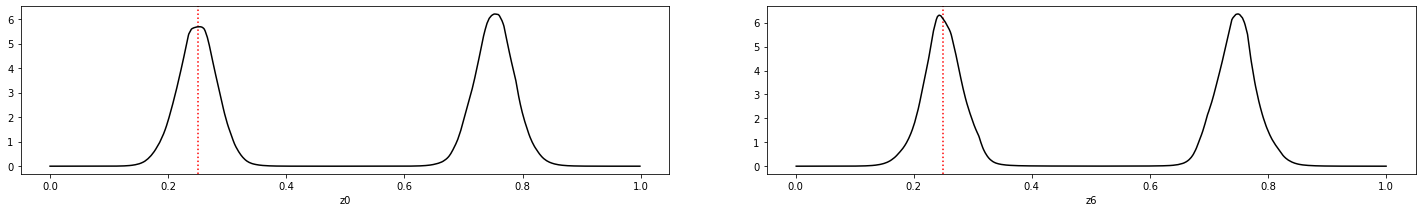

In [16]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (25, 3), ncol = 2, params = [0, 6])

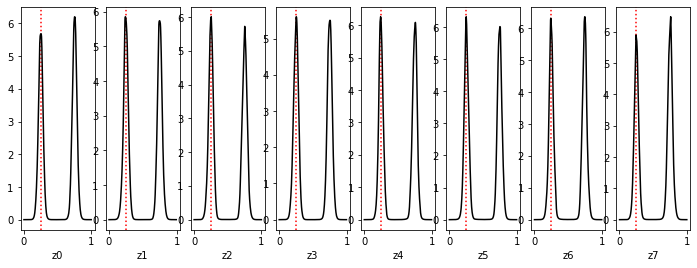

In [17]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (12, 4))

In [ ]:
re2 = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = swyft.comb2d([0, 1]), head = Head)
re2.train(max_epochs = MAX_EPOCHS, nbatch = 32, early_stopping_patience = 3, lr_schedule = [1e-3, 5e-4])

In [ ]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 15, Nmax = 10000)

In [ ]:
ds = td.get_dataset()
zs = np.array([d['z'].numpy() for d in ds])
plt.scatter(zs[:,0], zs[:,1])